In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

raw = pd.read_csv('stock_prices_10yr_all_companies.csv', header=None)

tickers = raw.iloc[0, 1:].values
features = raw.iloc[1, 1:].values
columns = ['Date'] + [f'{tickers[i]}_{features[i]}' for i in range(len(tickers))]

df = pd.DataFrame(raw.values[2:], columns=columns)

# Cleanup
df = df[df['Date'].astype(str) != 'Date']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.dropna(subset=['Date'])  # drop rows with invalid dates

            Date          Close_CHTR         Close_CMCSA          Close_DIS  \
0           Date                 NaN                 NaN                NaN   
1     2015-04-06  193.19000244140625  23.233482360839844   97.2472152709961   
2     2015-04-07              189.75  23.277387619018555   97.0630874633789   
3     2015-04-08  190.77999877929688   23.62064552307129   97.9192886352539   
4     2015-04-09  190.92999267578125   23.78428840637207  98.29674530029297   
...          ...                 ...                 ...                ...   
2513  2025-03-31   368.5299987792969  36.568382263183594  98.69999694824219   
2514  2025-04-01   370.9100036621094   36.38999938964844  97.68000030517578   
2515  2025-04-02   379.2699890136719   36.61000061035156  97.87999725341797   
2516  2025-04-03   368.3999938964844  35.720001220703125  88.83999633789062   
2517  2025-04-04   338.2900085449219  33.380001068115234  83.52999877929688   

             Close_GOOGL         Close_META        

Trend prediction accuracy for GOOGL: 55.06%

Sample predictions:
2023-12-29 | Close: $139.03 | Signal: Buy
2024-01-02 | Close: $137.51 | Signal: Buy
2024-01-03 | Close: $138.26 | Signal: Buy
2024-01-04 | Close: $135.74 | Signal: Buy
2024-01-05 | Close: $135.08 | Signal: Buy
2024-01-08 | Close: $138.18 | Signal: Buy
2024-01-09 | Close: $140.28 | Signal: Buy
2024-01-10 | Close: $141.60 | Signal: Buy
2024-01-11 | Close: $141.40 | Signal: Buy
2024-01-12 | Close: $141.97 | Signal: Buy


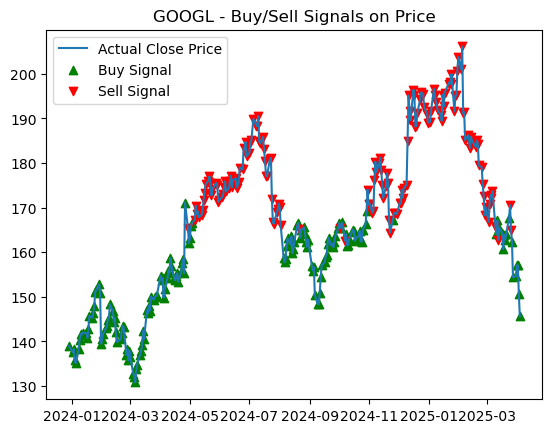

Trend prediction accuracy for META: 46.52%

Sample predictions:
2023-12-29 | Close: $352.30 | Signal: Sell
2024-01-02 | Close: $344.67 | Signal: Buy
2024-01-03 | Close: $342.85 | Signal: Buy
2024-01-04 | Close: $345.49 | Signal: Buy
2024-01-05 | Close: $350.30 | Signal: Buy
2024-01-08 | Close: $356.98 | Signal: Buy
2024-01-09 | Close: $355.75 | Signal: Sell
2024-01-10 | Close: $368.73 | Signal: Sell
2024-01-11 | Close: $367.94 | Signal: Sell
2024-01-12 | Close: $372.73 | Signal: Sell


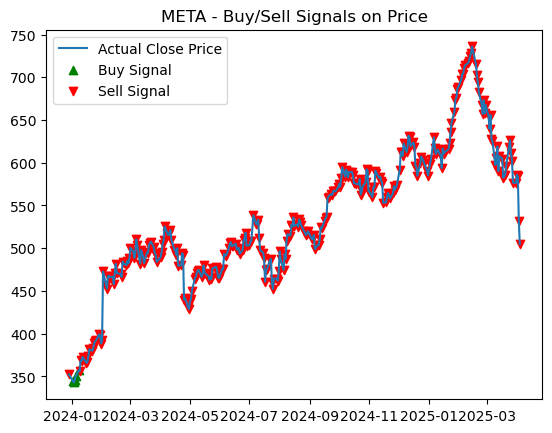

Trend prediction accuracy for NFLX: 49.05%

Sample predictions:
2023-12-29 | Close: $486.88 | Signal: Buy
2024-01-02 | Close: $468.50 | Signal: Buy
2024-01-03 | Close: $470.26 | Signal: Buy
2024-01-04 | Close: $474.67 | Signal: Buy
2024-01-05 | Close: $474.06 | Signal: Buy
2024-01-08 | Close: $485.03 | Signal: Buy
2024-01-09 | Close: $482.09 | Signal: Buy
2024-01-10 | Close: $478.33 | Signal: Buy
2024-01-11 | Close: $492.23 | Signal: Buy
2024-01-12 | Close: $492.16 | Signal: Buy


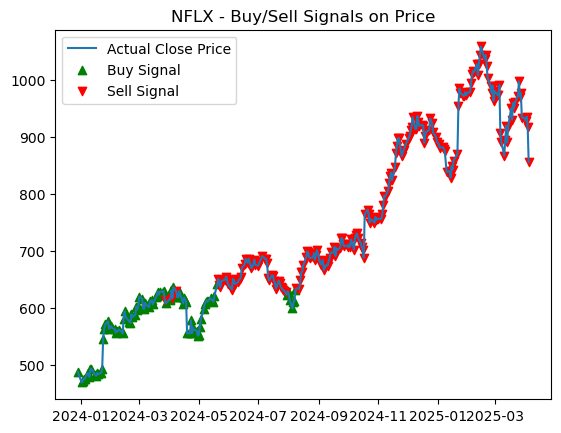

Trend prediction accuracy for TMUS: 42.72%

Sample predictions:
2023-12-29 | Close: $157.47 | Signal: Sell
2024-01-02 | Close: $159.02 | Signal: Sell
2024-01-03 | Close: $159.19 | Signal: Sell
2024-01-04 | Close: $159.41 | Signal: Sell
2024-01-05 | Close: $160.46 | Signal: Sell
2024-01-08 | Close: $160.50 | Signal: Sell
2024-01-09 | Close: $160.29 | Signal: Sell
2024-01-10 | Close: $160.38 | Signal: Sell
2024-01-11 | Close: $159.28 | Signal: Sell
2024-01-12 | Close: $159.64 | Signal: Sell


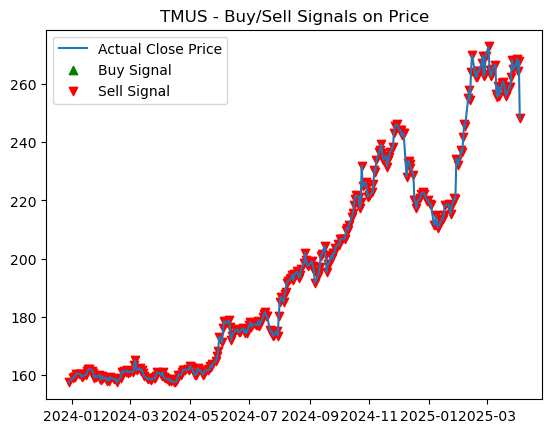

Trend prediction accuracy for DIS: 49.68%

Sample predictions:
2023-12-29 | Close: $89.48 | Signal: Buy
2024-01-02 | Close: $89.90 | Signal: Buy
2024-01-03 | Close: $90.83 | Signal: Buy
2024-01-04 | Close: $89.75 | Signal: Buy
2024-01-05 | Close: $90.08 | Signal: Buy
2024-01-08 | Close: $90.73 | Signal: Buy
2024-01-09 | Close: $88.86 | Signal: Buy
2024-01-10 | Close: $88.49 | Signal: Buy
2024-01-11 | Close: $88.65 | Signal: Buy
2024-01-12 | Close: $89.54 | Signal: Buy


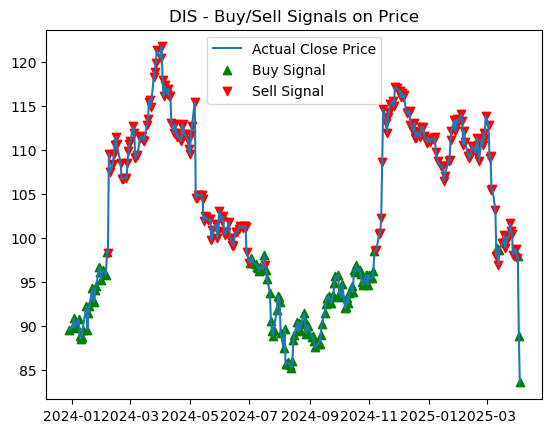

Trend prediction accuracy for T: 47.47%

Sample predictions:
2023-12-29 | Close: $15.60 | Signal: Buy
2024-01-02 | Close: $16.04 | Signal: Buy
2024-01-03 | Close: $16.02 | Signal: Buy
2024-01-04 | Close: $15.95 | Signal: Buy
2024-01-05 | Close: $16.25 | Signal: Buy
2024-01-08 | Close: $16.11 | Signal: Buy
2024-01-09 | Close: $16.02 | Signal: Buy
2024-01-10 | Close: $15.94 | Signal: Buy
2024-01-11 | Close: $15.34 | Signal: Buy
2024-01-12 | Close: $15.57 | Signal: Buy


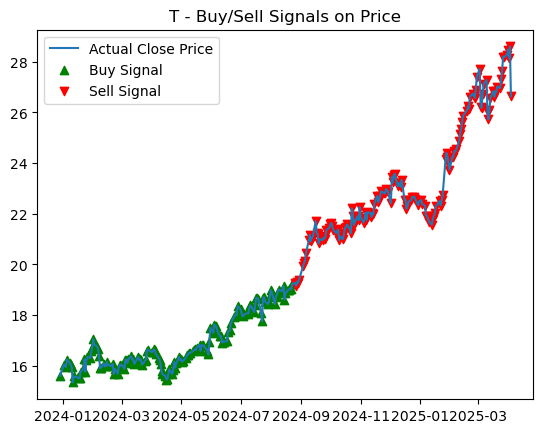

Trend prediction accuracy for VZ: 52.53%

Sample predictions:
2023-12-29 | Close: $34.73 | Signal: Buy
2024-01-02 | Close: $35.82 | Signal: Buy
2024-01-03 | Close: $36.07 | Signal: Buy
2024-01-04 | Close: $36.27 | Signal: Buy
2024-01-05 | Close: $37.03 | Signal: Buy
2024-01-08 | Close: $36.94 | Signal: Buy
2024-01-09 | Close: $36.57 | Signal: Buy
2024-01-10 | Close: $36.61 | Signal: Buy
2024-01-11 | Close: $35.50 | Signal: Buy
2024-01-12 | Close: $36.12 | Signal: Buy


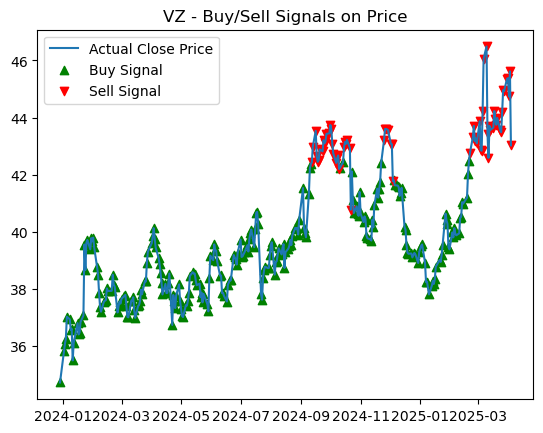

Trend prediction accuracy for CMCSA: 47.15%

Sample predictions:
2023-12-29 | Close: $41.84 | Signal: Buy
2024-01-02 | Close: $41.94 | Signal: Buy
2024-01-03 | Close: $41.60 | Signal: Buy
2024-01-04 | Close: $40.94 | Signal: Buy
2024-01-05 | Close: $41.34 | Signal: Buy
2024-01-08 | Close: $42.00 | Signal: Buy
2024-01-09 | Close: $41.57 | Signal: Buy
2024-01-10 | Close: $41.76 | Signal: Buy
2024-01-11 | Close: $41.56 | Signal: Buy
2024-01-12 | Close: $41.29 | Signal: Buy


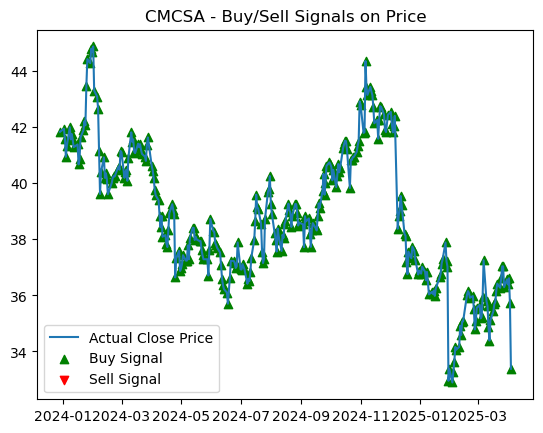

Trend prediction accuracy for SPOT: 46.84%

Sample predictions:
2023-12-29 | Close: $187.91 | Signal: Buy
2024-01-02 | Close: $188.80 | Signal: Buy
2024-01-03 | Close: $187.94 | Signal: Buy
2024-01-04 | Close: $192.58 | Signal: Buy
2024-01-05 | Close: $193.52 | Signal: Buy
2024-01-08 | Close: $197.25 | Signal: Buy
2024-01-09 | Close: $193.02 | Signal: Buy
2024-01-10 | Close: $196.79 | Signal: Buy
2024-01-11 | Close: $200.82 | Signal: Buy
2024-01-12 | Close: $203.03 | Signal: Buy


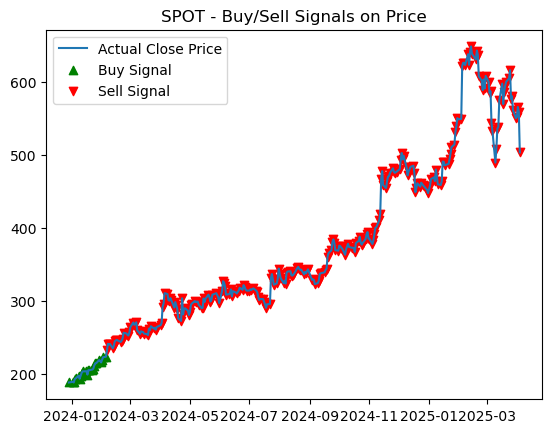

Trend prediction accuracy for CHTR: 47.78%

Sample predictions:
2023-12-29 | Close: $388.68 | Signal: Buy
2024-01-02 | Close: $391.51 | Signal: Buy
2024-01-03 | Close: $386.67 | Signal: Buy
2024-01-04 | Close: $375.75 | Signal: Buy
2024-01-05 | Close: $372.20 | Signal: Buy
2024-01-08 | Close: $378.87 | Signal: Buy
2024-01-09 | Close: $368.61 | Signal: Buy
2024-01-10 | Close: $367.00 | Signal: Buy
2024-01-11 | Close: $367.62 | Signal: Buy
2024-01-12 | Close: $364.90 | Signal: Buy


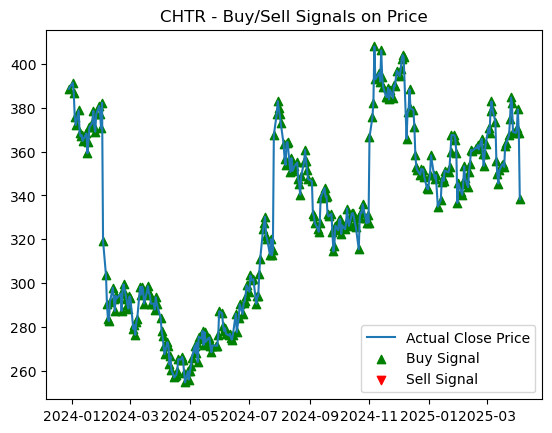

In [74]:
targets = "GOOGL", "META", "NFLX", "TMUS", "DIS", "T", "VZ", "CMCSA", "SPOT", "CHTR"
for target in targets:
    temp_df = df.copy()
    cols = [f'Close_{target}', f'High_{target}', f'Low_{target}']
    temp_df[cols] = temp_df[cols].astype(float)
    temp_df['Prev_Close'] = temp_df[f'Close_{target}'].shift(1)
    temp_df['Target_Up'] = (temp_df[f'Close_{target}'] > temp_df['Prev_Close']).astype(int)

    temp_df.dropna(inplace=True)
    
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(temp_df[['Prev_Close']])

    X = scaled
    y = temp_df['Target_Up'].values

    split = int(len(X) * 0.8)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    dates_test = temp_df['Date'].iloc[split:]
    real_close = temp_df[f'Close_{target}'].iloc[split:].values

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    signals = np.where(y_pred == 1, 'Buy', 'Sell')

    real_trend = np.where(np.diff(real_close) > 0, 1, 0)
    pred_trend = y_pred[:-1]
    trend_accuracy = accuracy_score(real_trend, pred_trend)

    print(f"Trend prediction accuracy for {target}: {trend_accuracy:.2%}")
    print("\nSample predictions:")
    for i in range(10):
        print(f"{dates_test.iloc[i].date()} | Close: ${real_close[i]:.2f} | Signal: {signals[i]}")
    plt.plot(dates_test, real_close, label="Actual Close Price")

    # Overlay buy/sell signals
    buy_signals = dates_test[y_pred == 1]
    sell_signals = dates_test[y_pred == 0]

    plt.scatter(buy_signals, real_close[y_pred == 1], marker='^', color='g', label='Buy Signal')
    plt.scatter(sell_signals, real_close[y_pred == 0], marker='v', color='r', label='Sell Signal')

    plt.legend()
    plt.title(f"{target} - Buy/Sell Signals on Price")
    plt.show()